### Content:
- Train text classifier on custom labels (market sematic)

#### TODO:
- Grid Testing for Parameters
- Validate features by looking at most important words for each class
- Have a look into Temporal Correlation, ApEN & Cramers V, Hatemining, Related Work Text Classification
- Add pretrained WordEmbedding (e.g. BERT)

#### Update:
- Remove all entities before Vectorizer
- SpaCy: Find all types of entities in all news articles and store in CSV ("nlp(doc, disable=['parser', 'ner'])")
- NaiveBayes instead of LinearSVC
- Filename_to_id for reuters and bloomberg
- Replace CountVectorizer mit TfidfVectorizer
- Don't trim to 200 words but by frequency (bag of words may be very large)
- Prepare Data & Write Janna

In [1]:
from notebook_utils import *
init()

Execute the following jupyter commands manually:
%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2


In [2]:
import glob
from datetime import datetime, timedelta
import itertools
import gc

from scipy.sparse import issparse
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, classification_report
import spacy
from spacy import displacy

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

### Load Data

In [3]:
from src.datasets import NyseSecuritiesDataset
from src.datasets import NyseStocksDataset
import src.nlp_utils as nlp_utils
import src.text_classification_utils as tc_utils

HOME = ".."
DATA_DIR = "data"
NEWS = os.path.join(HOME, DATA_DIR, "preprocessed", "news-v4.csv")
OCCS = os.path.join(HOME, DATA_DIR, "preprocessed", "occurrences", "occurrences.csv")
COOCCS = os.path.join(HOME, DATA_DIR, "preprocessed", "occurrences", "cooccurrences.csv")

stocks_ds = NyseStocksDataset(file_path='../data/nyse/prices-split-adjusted.csv'); stocks_ds.load()
securities_ds = NyseSecuritiesDataset(file_path='../data/nyse/securities.csv'); securities_ds.load()
companies = securities_ds.get_all_company_names()  # List[Tuple[symbol, name]]

occs_per_article = tc_utils.get_occs_per_article(OCCS)


time: 35.9 s


##### Define final test run

In [4]:
# Also contains prices from train for look back
stocks_test_ds = NyseStocksDataset(file_path='../data/nyse/prices-split-adjusted.csv', only_test=True, load=True)
all_news = pd.read_csv(NEWS, index_col=0, skiprows=range(1, 46481))
# news_test = tc_utils.load_news_clipped(stocks_test_ds, look_back=0, forecast=30, file_path=REUTERS)

def final_test(pipe, look_back=0, forecast=30, epsilon_daily_label=0.01, epsilon_overall_label=0.05, min_occurrences=5):
    # 60k articles
    news_test = tc_utils.load_news_clipped(stocks_test_ds, look_back, forecast, news=all_news)
    rel_article_tuples_test = tc_utils.get_relevant_articles(
        news_test, occs_per_article, securities_ds, min_occ=min_occurrences)
    rel_article_tuples_test = [x for x in rel_article_tuples_test
                               if stocks_test_ds.is_company_available(x[0])]

    X_test = np.array([nlp_utils.get_plain_content(x[1]) for x in rel_article_tuples_test])
    y_test = tc_utils.get_discrete_labels(
        rel_article_tuples_test, stocks_test_ds, look_back=look_back, forecast=forecast,
        epsilon_daily_label=epsilon_daily_label, epsilon_overall_label=epsilon_overall_label)
    print('Test distribution:', ''.join([f'"{cls}": {sum(y_test == cls)} samples; ' for cls in [1, -1, 0]]))

    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return acc, mcc, y_pred


time: 48.3 s


# Grid Tests

In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
# https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
# TODO: Remove not working models (e.g. GBC)
models = [
    LinearSVC(),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(C=1e-1, random_state=42),
    SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None),
    MLPClassifier(early_stopping=True, hidden_layer_sizes=(32, 32)),
    GradientBoostingClassifier()
]

In [ ]:
EPSILON_DAILY_LABEL = 0.01
EPSILON_OVERALL_LABEL = 0.05
# min_occ->amount_articles:
# 5->15048, 4->18499, 3->23256, 2->30675, 1->45816
MIN_OCCURRENCES = 5  # for one company
MAX_ARTICLES = 3000 # with min_occ=1 we get up to 25k

algorithm = GradientBoostingClassifier()
metrics = []
pipes = []

for time_delta in tqdm([x for x in [-100, -50, -30, -10, -5, -1, 1, 5, 10, 30, 50, 100] if x != 0]):
    print('-'*40, '\n', f'time_delta={time_delta}')
    look_back = abs(min(time_delta, 0))
    forecast = abs(max(time_delta, 0))
    pipe, val_acc, val_mcc, train_acc, train_mcc, data = tc_utils.run(
        stocks_ds, securities_ds, occs_per_article, news=all_news, time_delta=time_delta,
        epsilon_daily_label=EPSILON_DAILY_LABEL, epsilon_overall_label=EPSILON_OVERALL_LABEL,
        min_occurrences=MIN_OCCURRENCES, max_articles=MAX_ARTICLES, algorithm=algorithm)
    print('Data shape:', len(data[0]), len(data[1]), len(data[2]), len(data[3]))
    data = None
    gc.collect()
    test_acc, test_mcc, _ = final_test(
        pipe, look_back=look_back, forecast=forecast, epsilon_daily_label=EPSILON_DAILY_LABEL,
        epsilon_overall_label=EPSILON_OVERALL_LABEL, min_occurrences=MIN_OCCURRENCES)

    metrics.append((time_delta, test_acc, test_mcc, val_acc, val_mcc, train_acc, train_mcc))
    pipes.append(pipes)
    gc.collect()

---------------------------------------- 
 time_delta=-100
---------------------------------------- 
 look_back=100; forecast=0


Distribution: "1": 518 samples; "-1": 633 samples; "0": 1849 samples; 
Data shape: 2400 2400 600 600


Test distribution: "1": 554 samples; "-1": 113 samples; "0": 952 samples; 
---------------------------------------- 
 time_delta=-50
---------------------------------------- 
 look_back=50; forecast=0


Distribution: "1": 781 samples; "-1": 1000 samples; "0": 1219 samples; 
Data shape: 2400 2400 600 600


Test distribution: "1": 965 samples; "-1": 378 samples; "0": 969 samples; 
---------------------------------------- 
 time_delta=-30
---------------------------------------- 
 look_back=30; forecast=0


Distribution: "1": 859 samples; "-1": 1139 samples; "0": 1002 samples; 
Data shape: 2400 2400 600 600


Test distribution: "1": 1142 samples; "-1": 627 samples; "0": 850 samples; 
---------------------------------------- 
 time_delta=-10
---------------------------------------- 
 look_back=10; forecast=0


Distribution: "1": 1130 samples; "-1": 1219 samples; "0": 651 samples; 
Data shape: 2400 2400 600 600


Test distribution: "1": 1415 samples; "-1": 970 samples; "0": 612 samples; 
---------------------------------------- 
 time_delta=-5
---------------------------------------- 
 look_back=5; forecast=0


Distribution: "1": 1025 samples; "-1": 1078 samples; "0": 897 samples; 
Data shape: 2400 2400 600 600


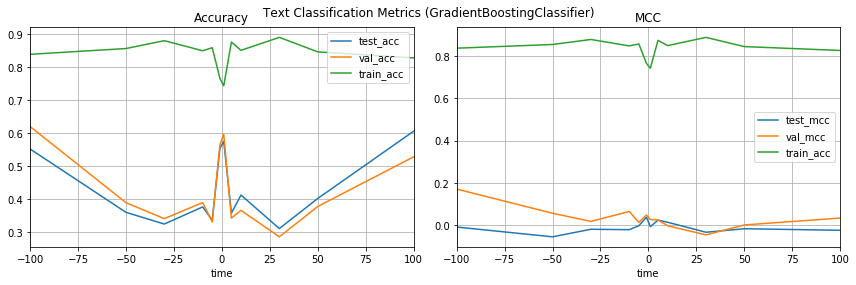

time: 1.53 s


In [9]:
metrics_df = pd.DataFrame(metrics, columns=['time', 'test_acc', 'test_mcc', 'val_acc', 'val_mcc', 'train_acc', 'train_mcc']).set_index('time')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
metrics_df[['test_acc', 'val_acc', 'train_acc']].plot(ax=axes[0], title='Accuracy', grid=True)
metrics_df[['test_mcc', 'val_mcc', 'train_acc']].plot(ax=axes[1], title='MCC', grid=True)
fig.suptitle(f'Text Classification Metrics ({algorithm.__class__.__name__})')
fig.tight_layout()
fig.savefig('all-news-TC-metrics-gb-mo5-ma3k.pdf')

# TODO:
- Plot with acc & val_acc for features from 50 to 5000D (https://nlp.stanford.edu/pubs/glove.pdf)
- Show misleading improvement by split_after_shuffle=True (will fail von the test set)

Tutorial: https://towardsdatascience.com/machine-learning-for-text-classification-using-spacy-in-python-b276b4051a49

### General Setting
- Use {LOOK_BACK} last days until open of the {FORECAST} day in the future (for articles on weekends go back to friday)
- Articles from NYSE start 2010-03-22 to Reuters end 2012-12-31 [not touched final test set will be 2013-01-01 to 2013-11-20 with 3901-2803=1098 articles]
- Only use title and real body (with some exceptions because of regex failure)
- (?) TODO: Don't remove numbers, links, special characters from vectorizer

Default parameters:
- LOOK_BACK = 30
- FORECAST = 0
- EPSILON_DAILY_LABEL = 0.01
- EPSILON_OVERALL_LABEL = 0.05
- Label "1": 829 samples, Label "-1": 1017 samples, Label "0": 957 samples
- Train: 2242 out of 2803 shuffled samples (Test: 561 samples)
- LinearSVC warns: "ConvergenceWarning: Liblinear failed to converge, increase the number of iterations."

## Optimizing Text Classification

Tutorial: https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

- Download `wiki-news-300d-1M.vec` (https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)
- Download `GoogleNews-vectors-negative300.bin.gz` (https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz)